# Monomer vs. Decemer

Comparison of partial charges in monometic aSyn with partial charges in decameric aSyn.

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import math
import os.path, os, sys, glob, json

plt.rcParams.update({'font.size': 16, 'figure.figsize': [10, 0.08]})

monomer_dir = 'monomer-pH6.5/'
decamer_dir = 'decamer-pH6.5/'

In [2]:
def resnames_to_fasta(resnames):
    ''' translate 3 letter residue names to FASTA letters '''
    fasta = []
    for resname in resnames:
        if 'ALA' in resname:
            fasta.append('A')
        elif 'ARG' in resname:
            fasta.append('R')
        elif 'ASN' in resname:
            fasta.append('N')
        elif 'ASP' in resname:
            fasta.append('D')
        elif 'CYS' in resname:
            fasta.append('C')
        elif 'GLU' in resname:
            fasta.append('E')
        elif 'GLN' in resname:
            fasta.append('Q')
        elif 'GLY' in resname:
            fasta.append('G')
        elif 'HIS' in resname:
            fasta.append('H')
        elif 'ILE' in resname:
            fasta.append('I')
        elif 'LEU' in resname:
            fasta.append('L')
        elif 'LYS' in resname:
            fasta.append('K')
        elif 'MET' in resname:
            fasta.append('M')
        elif 'PHE' in resname:
            fasta.append('F')
        elif 'PRO' in resname:
            fasta.append('P')
        elif 'SER' in resname:
            fasta.append('S')
        elif 'THR' in resname:
            fasta.append('T')
        elif 'TRP' in resname:
            fasta.append('W')
        elif 'TYR' in resname:
            fasta.append('Y')
        elif 'VAL' in resname:
            fasta.append('V')
        elif 'NTR' in resname:
            fasta.append('M') # hard-coded!
        elif 'CTR' in resname:
            fasta.append('A') # hard-coded!
        else:
            fasta.append('?')
    return fasta

directory = monomer-pH6.5/
monomeric charge = -3.222759999999999
decameric charge = -2.9790779999999994


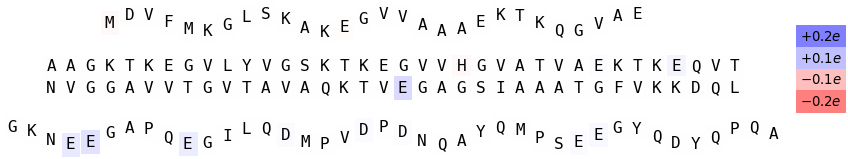

In [3]:
plt.rcParams.update({'font.size': 16, 'figure.figsize': [10, 0.08]})

def read_charge_and_fasta(file, molecule):
    ''' read average atom charges and residue names from Faunus output file '''
    with open(file) as f:
        j = json.load(f) # - -> dict
        for analysis in j['analysis']:
            if 'chargefluctuations' in analysis:
                if (analysis['chargefluctuations']['molecule'] == molecule):
                    charges = np.array(analysis['chargefluctuations']['<q>'])
                    resnames = analysis['chargefluctuations']['dominant atoms']
                    fasta = resnames_to_fasta(resnames)
                    return [charges, fasta]
    assert False, "Unknown file or molecule"

# Load average charges and FASTA letters. Then cleanup the data
# so that we can directly compare the simulations from a monomer
# with the simulations of the decamer. The reason for this data
# mangling is that the order of molecules in the decamer is different
# from the monomeric simulation. In addition there's a slight difference
# in how virtual CTR/NTR atoms are handled which we also need to take
# care of below.

def readMonomer(filename):
    monomer = read_charge_and_fasta(filename, 'protein')
    monomer[0] = np.delete(monomer[0], 140) # remove artificial/virtual CTR
    monomer[0] = np.delete(monomer[0], 1) # remove artificial/virtual NTR
    del monomer[1][140] # remove artificial/virtual CTR
    del monomer[1][1]   # remove artificial/virtual NTR
    return monomer

monomer = readMonomer(monomer_dir+'/out.json')

def readDecamer(filename):
    # Each variable below is a list with two elements; the first
    # contains average charges, the second the FASTA sequence
    ntr = read_charge_and_fasta(filename, 'ntr')
    rigid = read_charge_and_fasta(filename, 'protein')
    rigid[0] = rigid[0][0:72]
    rigid[1] = rigid[1][0:72]
    ctr = read_charge_and_fasta(filename, 'ctr')
    decamer = [np.concatenate((ntr[0], rigid[0], ctr[0]), axis=0),
               ntr[1] + rigid[1] + ctr[1]] # combined ntr -- rigid -- ctr
    return ntr, rigid, ctr, decamer

ntr, rigid, ctr, decamer = readDecamer(decamer_dir+'/out.json')

# lengths of each section (ntr -- rigid -- ctr)
N_ntr = len(ntr[0])
N_rigid = len(rigid[0])
N_ctr = len(ctr[0])
assert monomer[1] == decamer[1] # check that the FASTA sequences match!

fasta = monomer[1] # total fasta sequence (ntr -- ridid -- ctr)
print("directory =", monomer_dir)
print('monomeric charge =', monomer[0].sum())
print('decameric charge =', decamer[0].sum())

# Normalize the color map used for background colors
# of the fasta sequence. We want ZERO to be the midpoint, i.e. WHITE.
dq = decamer[0] - monomer[0] # delta charge
extreme = max([dq.min(), dq.max()], key=abs)
if (extreme<0):
    extreme = -extreme
norm = mpl.colors.Normalize(vmin=-0.4, vmax=0.4, clip=True)

mapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr) # 'bwr'

dx=0.035 # horizontal spacing between letters
for i in range(N_ntr): # plot ntr fasta sequence (wavy)
    plt.text(5*dx + i*dx, 0 + 2*math.sin(i), fasta[i],
             backgroundcolor=mapper.to_rgba(dq[i]), family='monospace')

shift = 0
for i in range(N_rigid): # plot rigid fasta sequence (straight)
    j = i + N_ntr
    ypos = -10
    if i > 35:
        ypos = ypos * 1.5
        shift = 1
    plt.text(2*dx + i*dx - shift*36*dx, ypos, fasta[j],
             backgroundcolor=mapper.to_rgba(-dq[j]), family='monospace')
    
for i in range(N_ctr): # plot ctr fasta sequence (wavy)
    j = i + N_ntr + N_rigid
    plt.text(i*dx, -26 + 2*math.cos(i), fasta[j],
             backgroundcolor=mapper.to_rgba(-dq[j]), family='monospace')
plt.axis('off')

offset=-18
plt.text(1.42, 15+offset, '$+0.2e$', fontsize='small', backgroundcolor=mapper.to_rgba(-0.2), family='monospace')
plt.text(1.42, 10+offset, '$+0.1e$', fontsize='small', backgroundcolor=mapper.to_rgba(-0.1), family='monospace')
plt.text(1.42, 5+offset, '$-0.1e$', fontsize='small', backgroundcolor=mapper.to_rgba(0.1), family='monospace')
plt.text(1.42, 0+offset, '$-0.2e$', fontsize='small', backgroundcolor=mapper.to_rgba(0.2), family='monospace')

plt.savefig('fasta-difference-5Q.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

## Ionization of individual carboxyal groups in ASP and GLU

The vertical, dashed line corresponds to the a-syn iso-electric point (~4.5) which is roughly the same regardless if it is in the monomer or in the decamer (see table below). The dashed titration curve is the ideal charge simply using the model pKa-value.

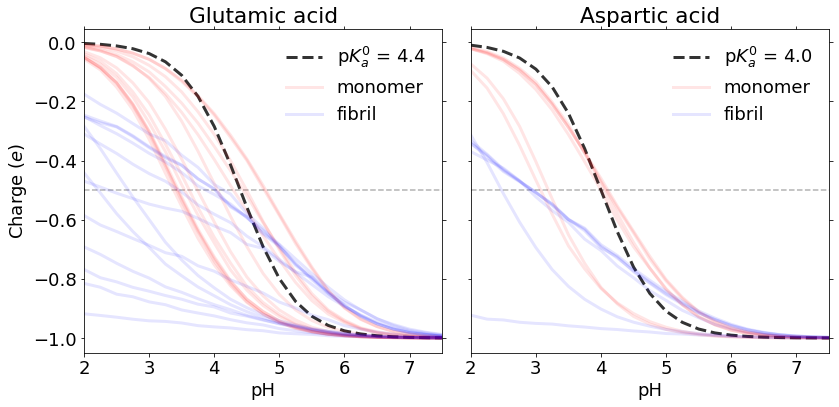

In [4]:
pH_range = np.arange(2, 8, 0.25)
names = []
db_monomer = {}
db_decamer = {}
for pH in pH_range:
    monomer = readMonomer('monomer-pH{}/out.json'.format(pH))
    ntr, rigid, ctr, decamer = readDecamer('decamer-pH{}/out.json'.format(pH))
    db_monomer[pH] = monomer[0]
    db_decamer[pH] = decamer[0]
    names = decamer[1]

names = ["{}{}".format(name, number+1) for name, number in zip(names, range(len(names)))]

def ideal_charge(pH, pKa):
    return -10**(pH-pKa) / (1+10**(pH-pKa))

def mangle_db(db, regex):
    ''' filter and organize database '''
    _db = pd.DataFrame(db, index = names).T
    mask = _db.filter(regex=regex).columns # select glutamic acid (E) and/or aspartic acid (D)
    return _db[mask]

def plotResidue(ax, pKa, regex):
    alpha=0.1
    monomer = mangle_db(db_monomer, regex)
    decamer = mangle_db(db_decamer, regex)

    ax.axhline(y=-0.5, color='k', linestyle='--', alpha=0.3)
    ax.plot(pH_range, ideal_charge(pH_range, pKa), 'k--', label=r"p$K_a^0$ = {}".format(pKa), lw=3, alpha=0.8)
    label = 'monomer'
    for i in monomer.iteritems():
        ax.plot(i[1], 'r-', alpha=alpha, label=label, lw=3)
        label=''
    label = 'fibril'
    for i in decamer.iteritems():
        ax.plot(i[1], 'b-', alpha=alpha, label=label, lw=3)
        label=''
    ax.legend(loc=0, frameon=False, handlelength=2)
    ax.tick_params(top=True, right=True)

plt.rcParams.update({'font.size': 18, 'figure.figsize': [12, 6]})
fig, ax = plt.subplots(1,2, sharex=True, sharey=True)
ax[0].set_xlabel('pH')
ax[1].set_xlabel('pH')
ax[0].set_ylabel('Charge ($e$)')
ax[0].set_xlim(2, 7.5)
ax[0].set_title('Glutamic acid')

ax[1].set_title('Aspartic acid')
plotResidue(ax[0], 4.4, 'E') # glumatic acid
plotResidue(ax[1], 4.0, 'D') # aspartic acid
fig.tight_layout()

# aSyn net-charge as a function of pH

Here we extract the net-charge of a-syn as a monomer (Q1) and when in the decamer (Q10).
At low pH, the net-positive decameric charge is reduced by _deprotonating_ GLU and ASP. This explains the flattening of the titration curve above.
Above the iso-electric point, pI~4.5, GLU and ASP starts to neutralize due to the net-negative charge. In this region, the ASP and GLU charges are less negative compared to the ideal (dashed line).


In [5]:
monomer = mangle_db(db_monomer, ".")
decamer = mangle_db(db_decamer, ".")
Qmonomer = []
Qdecamer = []
for i in monomer.iterrows():
    Qmonomer.append(i[1].sum())
for i in decamer.iterrows():
    Qdecamer.append(i[1].sum())
print('{:>6} {:>6} {:>6}'.format("pH", "Q1", "Q10"))
for pH, Q1, Q2 in zip(pH_range, Qmonomer, Qdecamer):
    print("{:6.2f} {:6.2f} {:6.2f}".format(pH, Q1, Q2))

    pH     Q1    Q10
  2.00  16.31   7.65
  2.25  15.85   6.93
  2.50  15.14   6.22
  2.75  14.11   5.49
  3.00  12.80   4.76
  3.25  11.18   4.10
  3.50   9.41   3.44
  3.75   7.60   2.75
  4.00   5.82   2.12
  4.25   4.14   1.50
  4.50   2.63   0.87
  4.75   1.29   0.30
  5.00   0.14  -0.30
  5.25  -0.80  -0.87
  5.50  -1.57  -1.37
  5.75  -2.16  -1.87
  6.00  -2.60  -2.31
  6.25  -2.94  -2.66
  6.50  -3.22  -2.98
  6.75  -3.47  -3.23
  7.00  -3.68  -3.44
  7.25  -3.86  -3.64
  7.50  -4.03  -3.80
  7.75  -4.20  -3.95


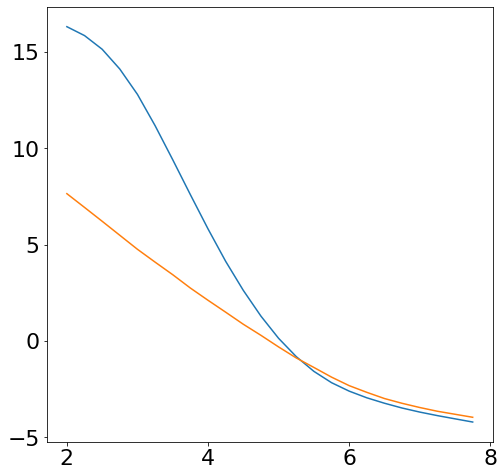

In [6]:
plt.rcParams.update({'font.size': 22, 'figure.figsize': [8, 8]})
plt.plot(pH_range, Qmonomer)
plt.plot(pH_range, Qdecamer)